In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta
import warnings
warnings.simplefilter("ignore") # Because I'm chaotic 
import time

In [2]:
def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    return ds1, grid1

paths = ['/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc',
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_u3hc4_uwind_osc_1/shelf_dx_500_u3hc4_uwind_osc_1_avg.nc', 
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_hsimt_uwind_osc_1/shelf_dx_500_hsimt_uwind_osc_1_avg.nc']
 
ds = []
grid = []
for i in range(len(paths)):
    ds1, grid1 = open_roms(paths[i])
    ds.append(ds1)
    grid.append(grid1)

xislice = slice(1,-1) #Exclude boundary points bc periodic BC
etaslice = slice(1,100) # Initially stratified region
tslice = slice(156,337) # Days 7.5-15 

In [3]:
sbins = np.arange(26.9,35.1,0.2) # Redefine them 
vhist = []
start = time.time()
for i in range(len(paths)):
    #Slice salinity and dV for histograms
    salt = ds[i].salt.isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)).where(ds[i].z_rho>-1)
    salt = salt.fillna(0) #fill nans 
    salt.attrs = ''
    salt.name = 'salt'
    
    dV = ds[i].dV.isel(ocean_time = tslice, xi_rho = slice(1,-1), eta_rho = slice(1,-1)).where(ds[i].z_rho>-1)
    dV = dV.fillna(0)
    dV.attrs = ''
    
    vhist1 = histogram(salt, bins = [sbins], weights = dV, dim = ['s_rho', 'eta_rho', 'xi_rho']) 
    vhist1.attrs = ''
    vhist1.name = 'dV'
    vhist.append(vhist1.load())
    
    elap_time = (time.time() - start) 
    print('Iter. complete in sec.', elap_time)

Iter. complete in sec. 22.61370348930359
Iter. complete in sec. 44.753700733184814
Iter. complete in sec. 67.24911212921143


Text(0.5, 1.0, 'Volume-weighted histogram of salinity')

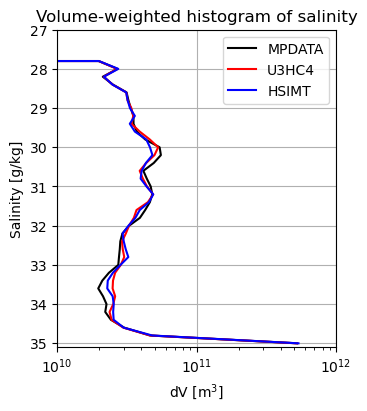

In [4]:
fig, ax = plt.subplots(1,1, figsize = (3.5*1,4), sharex = True, sharey= True, constrained_layout = True)

plt.semilogx(vhist[0].sum('ocean_time'), vhist[0].salt_bin, c = 'k', label = r'MPDATA')
plt.semilogx(vhist[1].sum('ocean_time'), vhist[0].salt_bin, c = 'r', label = r'U3HC4')
plt.semilogx(vhist[2].sum('ocean_time'), vhist[0].salt_bin, c = 'b', label = r'HSIMT')
plt.gca().invert_yaxis()
plt.grid()
plt.xlim(1e10, 1e12)
plt.ylim(35.1,27)
plt.legend()
plt.xlabel(r'dV [m$^3$]')
plt.ylabel(r'Salinity [g/kg]')
plt.title('Volume-weighted histogram of salinity')

In [9]:
dsalt = (vhist[0].salt_bin[1]-vhist[0].salt_bin[0]).values

Vs = []
for i in range(len(paths)):
    v_s = vhist[i].diff('salt_bin')/dsalt
    Vs.append(v_s)

Text(0.5, 1.0, '|Volume per salinity class|')

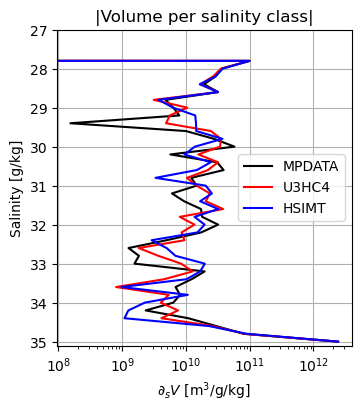

In [10]:
fig, ax = plt.subplots(1,1, figsize = (3.5*1,4), sharex = True, sharey= True, constrained_layout = True)

plt.semilogx(np.abs(Vs[0].sum('ocean_time')), Vs[0].salt_bin, c = 'k', label = r'MPDATA')
plt.semilogx(np.abs(Vs[1].sum('ocean_time')), Vs[0].salt_bin, c = 'r', label = r'U3HC4')
plt.semilogx(np.abs(Vs[2].sum('ocean_time')), Vs[0].salt_bin, c = 'b', label = r'HSIMT')
plt.gca().invert_yaxis()
plt.grid()
# plt.xlim(1e10, 1e12)
plt.ylim(35.1,27)
plt.legend()
plt.xlabel(r'$\partial_s V$ [m$^3$/g/kg]')
plt.ylabel(r'Salinity [g/kg]')
plt.title('|Volume per salinity class|')

In [5]:
time = np.arange(0,len(vhist[0].ocean_time))/24 #Crude time vector, could do this a fancier way but meh. 
time+=7.5# define time vector for plotting 

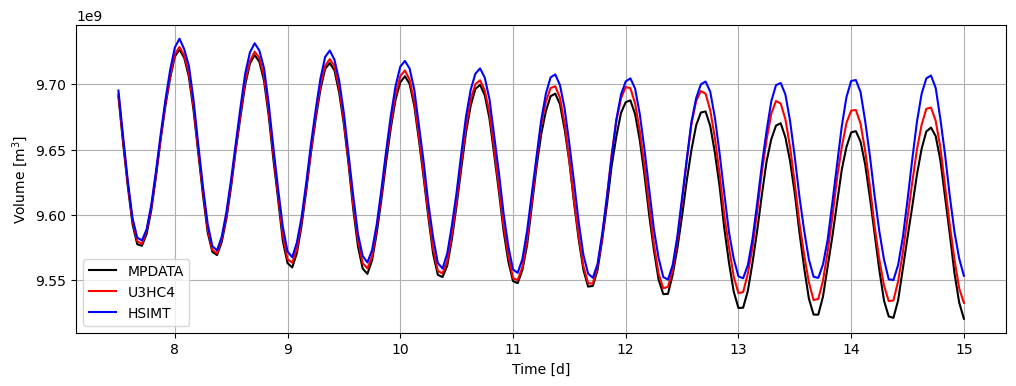

In [6]:
fig, ax = plt.subplots(1, figsize = (12,4))

plt.plot(time, vhist[0].sum('salt_bin'), c = 'k', label = 'MPDATA')
plt.plot(time, vhist[1].sum('salt_bin'), c = 'r', label = 'U3HC4')
plt.plot(time, vhist[2].sum('salt_bin'), c = 'b', label = 'HSIMT')
plt.grid()
plt.xlabel('Time [d]')
plt.ylabel('Volume [m$^3$]')
plt.legend()

Text(0.5, 0, 'Time [d]')

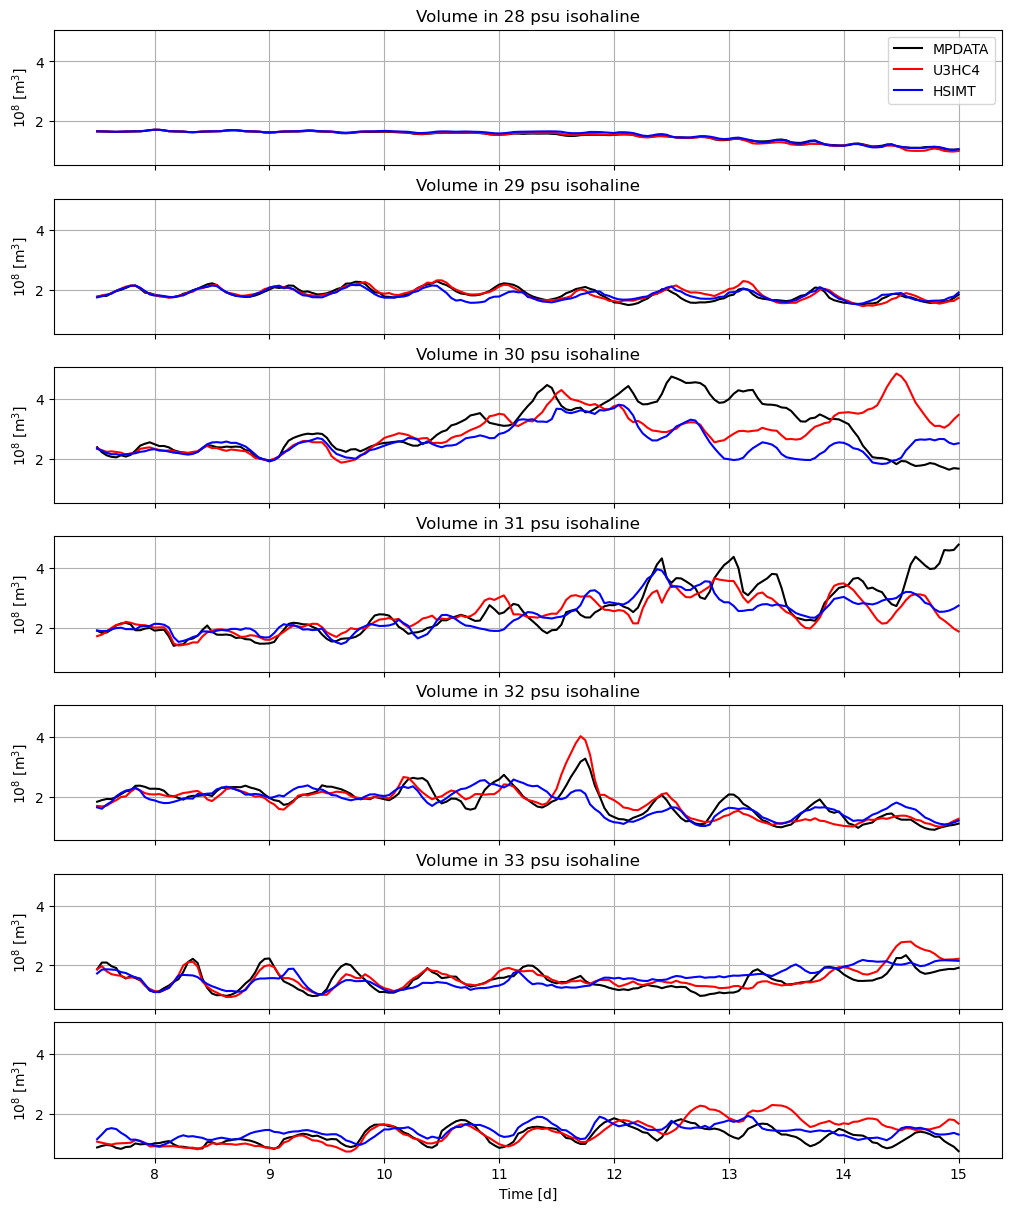

In [7]:
nrows = 7 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,12), constrained_layout = True, sharey = True)

ax[0].plot(time, vhist[0].sel(salt_bin=28, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, vhist[1].sel(salt_bin=28, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, vhist[2].sel(salt_bin=28, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, vhist[0].sel(salt_bin=29, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, vhist[1].sel(salt_bin=29, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, vhist[2].sel(salt_bin=29, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, vhist[0].sel(salt_bin=30, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, vhist[1].sel(salt_bin=30, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, vhist[2].sel(salt_bin=30, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, vhist[0].sel(salt_bin=31, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, vhist[1].sel(salt_bin=31, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, vhist[2].sel(salt_bin=31, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, vhist[0].sel(salt_bin=32, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, vhist[1].sel(salt_bin=32, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, vhist[2].sel(salt_bin=32, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, vhist[0].sel(salt_bin=33, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, vhist[1].sel(salt_bin=33, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, vhist[2].sel(salt_bin=33, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, vhist[0].sel(salt_bin=34, method = 'nearest')/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, vhist[1].sel(salt_bin=34, method = 'nearest')/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, vhist[2].sel(salt_bin=34, method = 'nearest')/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'10$^8$ [m$^3$]')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    ax[i].set_title('Volume in ' + str(28+i) + ' psu isohaline')
    
ax[0].legend()
ax[-1].set_xlabel('Time [d]')

### Integrate over a salinity range instead to avoid sensitivity to number of histogram bins.
Use 1 psu intervals

Text(0.5, 1.0, 'Volume in 34-35 salinity range')

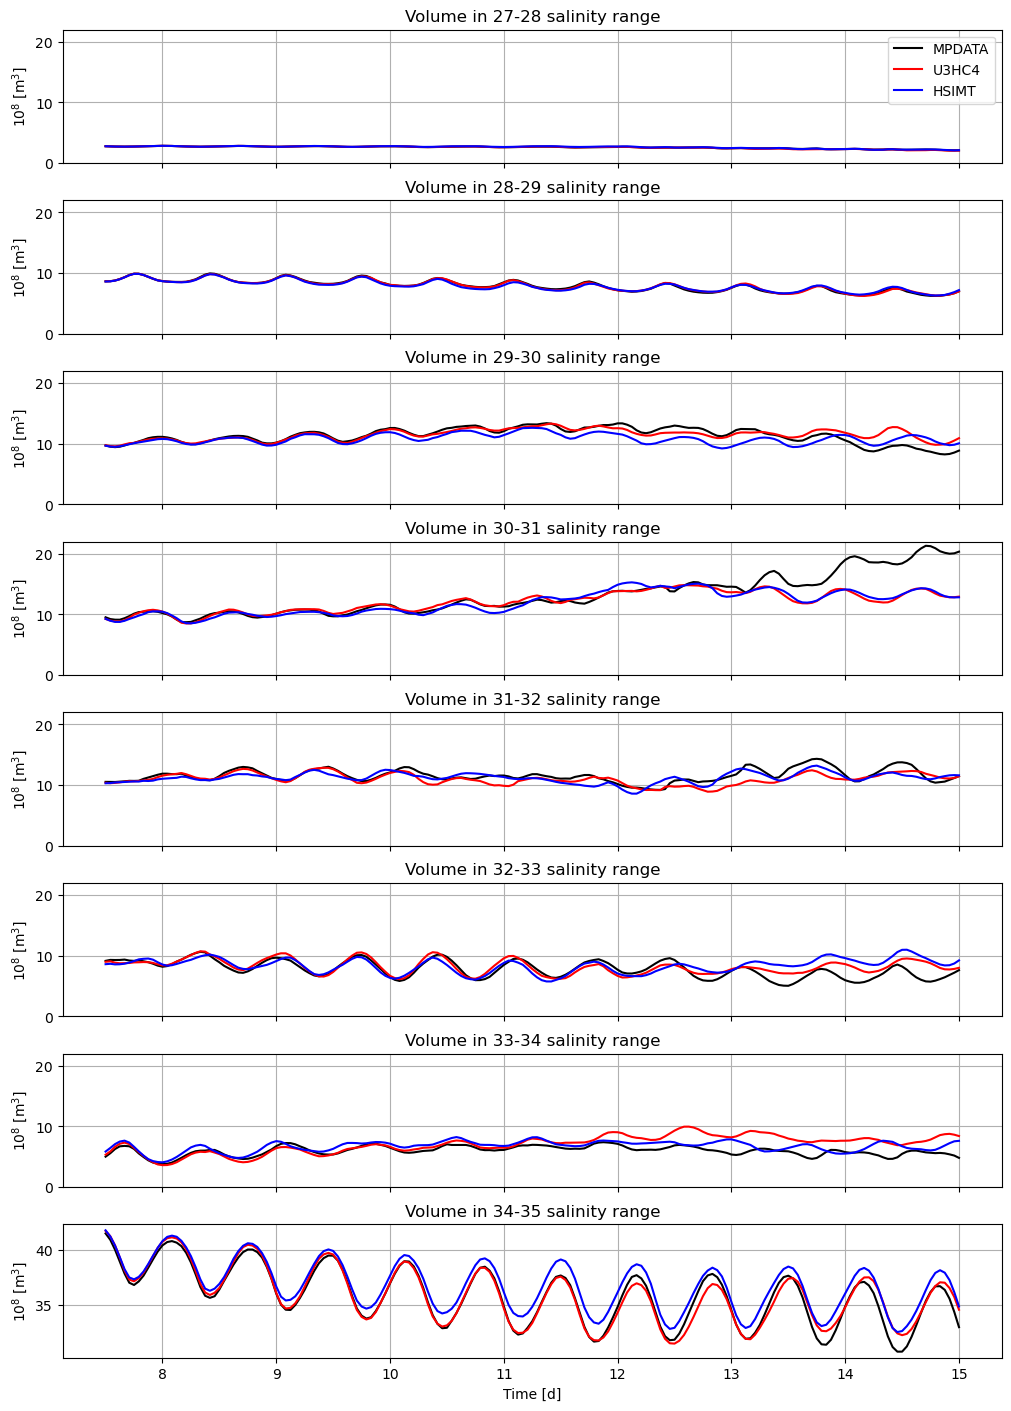

In [21]:
nrows = 8 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,2*7), constrained_layout = True, sharey = False)

ax[0].plot(time, ((vhist[0]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, ((vhist[1]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, ((vhist[2]).sel(salt_bin = slice(27,28)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, ((vhist[0]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, ((vhist[1]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, ((vhist[2]).sel(salt_bin = slice(28,29)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, ((vhist[0]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, ((vhist[1]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, ((vhist[2]).sel(salt_bin = slice(29,30)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, ((vhist[0]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, ((vhist[1]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, ((vhist[2]).sel(salt_bin = slice(30,31)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, ((vhist[0]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, ((vhist[1]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, ((vhist[2]).sel(salt_bin = slice(31,32)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, ((vhist[0]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, ((vhist[1]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, ((vhist[2]).sel(salt_bin = slice(32,33)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, ((vhist[0]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, ((vhist[1]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, ((vhist[2]).sel(salt_bin = slice(33,34)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')


ax[7].plot(time, ((vhist[0]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'k', lw = 1.5, label = 'MPDATA')
ax[7].plot(time, ((vhist[1]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'r', lw = 1.5, label = 'U3HC4')
ax[7].plot(time, ((vhist[2]).sel(salt_bin = slice(34,35)).sum('salt_bin'))/10**8, c = 'b', lw = 1.5, label = 'HSIMT')
ax[7].get_shared_y_axes().remove(ax[7])

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'10$^8$ [m$^3$]')
    ax[i].set_title('Volume in ' + str(27+i) + ' psu isohaline')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    ax[i].set_ylim(0,22)
    
ax[0].legend()
ax[-1].set_xlabel('Time [d]')

ax[0].set_title('Volume in ' + '27-28' + ' salinity range')
ax[1].set_title('Volume in ' + '28-29' + ' salinity range')
ax[2].set_title('Volume in ' + '29-30' + ' salinity range')
ax[3].set_title('Volume in ' + '30-31' + ' salinity range')
ax[4].set_title('Volume in ' + '31-32' + ' salinity range')
ax[5].set_title('Volume in ' + '32-33' + ' salinity range')
ax[6].set_title('Volume in ' + '33-34' + ' salinity range')
ax[7].set_title('Volume in ' + '34-35' + ' salinity range')

In [44]:
t = np.arange(0,len(vhist[0].ocean_time))/24
t+=7.5
time = t[1:]

Text(0.5, 1.0, '$\\frac{d}{dt}$ Vol. in 34-35 salinity range')

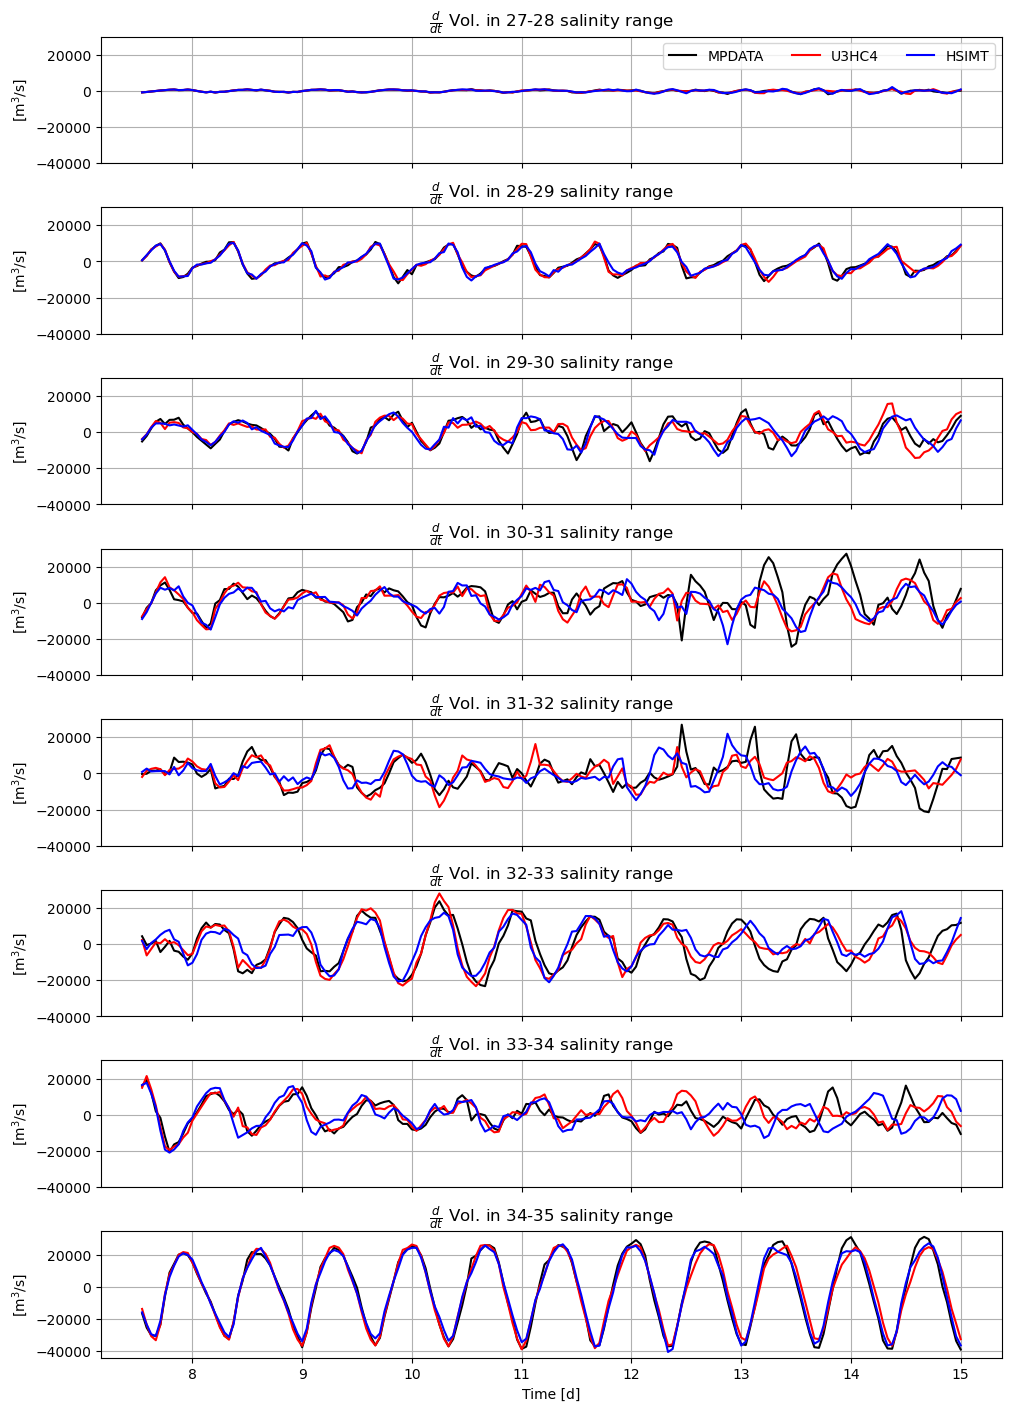

In [51]:
nrows = 8 ; ncols = 1
fig, ax = plt.subplots(nrows,ncols, figsize = (10,2*7), constrained_layout = True, sharey = False)

ax[0].plot(time, ((vhist[0]).sel(salt_bin = slice(27,28)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[0].plot(time, ((vhist[1]).sel(salt_bin = slice(27,28)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[0].plot(time, ((vhist[2]).sel(salt_bin = slice(27,28)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[1].plot(time, ((vhist[0]).sel(salt_bin = slice(28,29)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[1].plot(time, ((vhist[1]).sel(salt_bin = slice(28,29)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[1].plot(time, ((vhist[2]).sel(salt_bin = slice(28,29)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[2].plot(time, ((vhist[0]).sel(salt_bin = slice(29,30)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[2].plot(time, ((vhist[1]).sel(salt_bin = slice(29,30)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[2].plot(time, ((vhist[2]).sel(salt_bin = slice(29,30)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[3].plot(time, ((vhist[0]).sel(salt_bin = slice(30,31)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[3].plot(time, ((vhist[1]).sel(salt_bin = slice(30,31)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[3].plot(time, ((vhist[2]).sel(salt_bin = slice(30,31)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[4].plot(time, ((vhist[0]).sel(salt_bin = slice(31,32)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[4].plot(time, ((vhist[1]).sel(salt_bin = slice(31,32)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[4].plot(time, ((vhist[2]).sel(salt_bin = slice(31,32)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[5].plot(time, ((vhist[0]).sel(salt_bin = slice(32,33)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[5].plot(time, ((vhist[1]).sel(salt_bin = slice(32,33)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[5].plot(time, ((vhist[2]).sel(salt_bin = slice(32,33)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')

ax[6].plot(time, ((vhist[0]).sel(salt_bin = slice(33,34)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[6].plot(time, ((vhist[1]).sel(salt_bin = slice(33,34)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[6].plot(time, ((vhist[2]).sel(salt_bin = slice(33,34)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')


ax[7].plot(time, ((vhist[0]).sel(salt_bin = slice(34,35)).sum('salt_bin').diff('ocean_time')/3600), c = 'k', lw = 1.5, label = 'MPDATA')
ax[7].plot(time, ((vhist[1]).sel(salt_bin = slice(34,35)).sum('salt_bin').diff('ocean_time')/3600), c = 'r', lw = 1.5, label = 'U3HC4')
ax[7].plot(time, ((vhist[2]).sel(salt_bin = slice(34,35)).sum('salt_bin').diff('ocean_time')/3600), c = 'b', lw = 1.5, label = 'HSIMT')
ax[7].get_shared_y_axes().remove(ax[7])

for i in range(nrows):
    ax[i].grid()
    ax[i].set_ylabel(r'[m$^3$/s]')
    ax[i].set_title('Volume in ' + str(27+i) + ' psu isohaline')
    
for i in range(nrows-1):
    ax[i].set_xticklabels('')
    ax[i].set_ylim(-40000,30000)
    
ax[0].legend(ncol = 3)
ax[-1].set_xlabel('Time [d]')

ax[0].set_title(r'$\frac{d}{dt}$ Vol. in ' + '27-28' + ' salinity range')
ax[1].set_title(r'$\frac{d}{dt}$ Vol. in ' + '28-29' + ' salinity range')
ax[2].set_title(r'$\frac{d}{dt}$ Vol. in ' + '29-30' + ' salinity range')
ax[3].set_title(r'$\frac{d}{dt}$ Vol. in ' + '30-31' + ' salinity range')
ax[4].set_title(r'$\frac{d}{dt}$ Vol. in ' + '31-32' + ' salinity range')
ax[5].set_title(r'$\frac{d}{dt}$ Vol. in ' + '32-33' + ' salinity range')
ax[6].set_title(r'$\frac{d}{dt}$ Vol. in ' + '33-34' + ' salinity range')
ax[7].set_title(r'$\frac{d}{dt}$ Vol. in ' + '34-35' + ' salinity range')

In [13]:
t = np.arange(0,len(vhist[0].ocean_time))/24
t+=7.5
S,T = np.meshgrid(vhist[0].salt_bin,t)
print(np.shape(T),np.shape(S),np.shape(vhist[0].T.values))

(181, 41) (181, 41) (41, 181)


### Make Hovmoller diagrams of the isohaline volume in salinity space 

Text(0.5, 1.0, 'HSIMT')

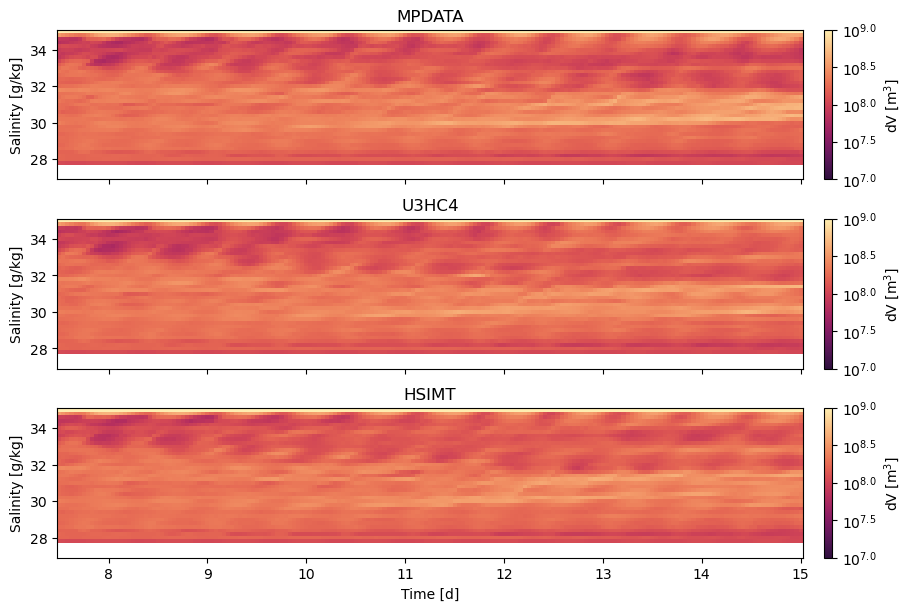

In [16]:
fig, ax = plt.subplots(3,1, figsize = (9,6), constrained_layout = True)

m = ax[0].pcolormesh(T, S, np.log10(vhist[0]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m1 = ax[1].pcolormesh(T, S, np.log10(vhist[1]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m2 = ax[2].pcolormesh(T, S, np.log10(vhist[2]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
fig.colorbar(m, ax = ax[0], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m1, ax = ax[1], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m2, ax = ax[2], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))

for i in range(3):
    ax[i].set_ylabel(r'Salinity [g/kg]')
    
for i in range(2):
    ax[i].set_xticklabels('')
    
ax[-1].set_xlabel('Time [d]')
ax[0].set_title('MPDATA')
ax[1].set_title('U3HC4')
ax[2].set_title('HSIMT')

### Plot the difference in volumes relative to MPDATA

Text(0.5, 1.0, 'MPDTATA-HSIMT')

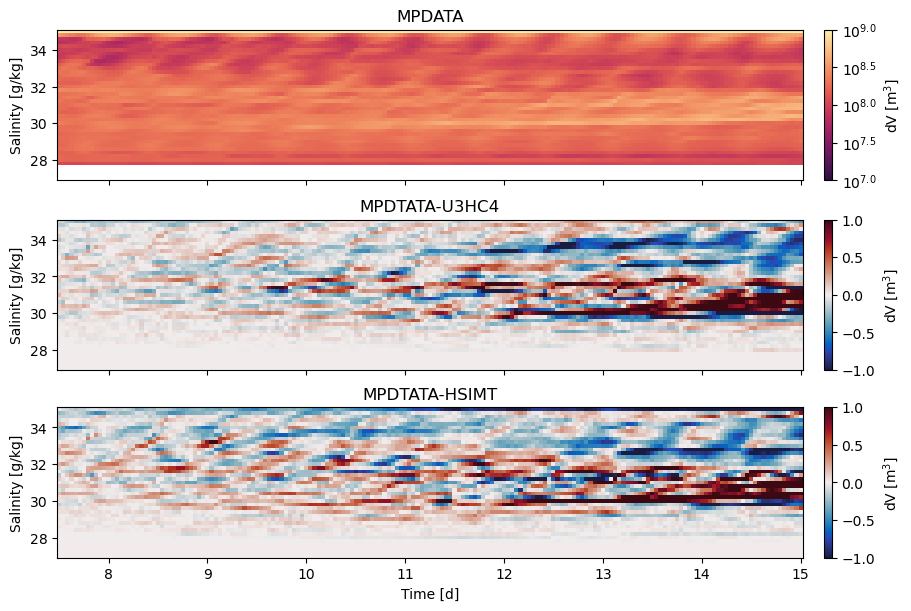

In [17]:
fig, ax = plt.subplots(3,1, figsize = (9,6), constrained_layout = True)

m = ax[0].pcolormesh(T, S, np.log10(vhist[0]), cmap = cmo.matter_r, vmin = 7, vmax = 9)
m1 = ax[1].pcolormesh(T, S, (vhist[0]-vhist[1])/1e8, cmap = cmo.balance, vmin = -1, vmax = 1)
m2 = ax[2].pcolormesh(T, S, (vhist[0]-vhist[2])/1e8, cmap = cmo.balance, vmin = -1, vmax = 1)
fig.colorbar(m, ax = ax[0], label = r'dV [m$^3$]', pad = 0.02, format = tick.FormatStrFormatter('$10^{%.1f}$'))
fig.colorbar(m1, ax = ax[1], label = r'dV [m$^3$]', pad = 0.02)
fig.colorbar(m2, ax = ax[2], label = r'dV [m$^3$]', pad = 0.02)

for i in range(3):
    ax[i].set_ylabel(r'Salinity [g/kg]')
    
for i in range(2):
    ax[i].set_xticklabels('')
    
ax[-1].set_xlabel('Time [d]')

ax[0].set_title('MPDATA')
ax[1].set_title('MPDTATA-U3HC4')
ax[2].set_title('MPDTATA-HSIMT')

Text(0.5, 0, 'Time [d]')

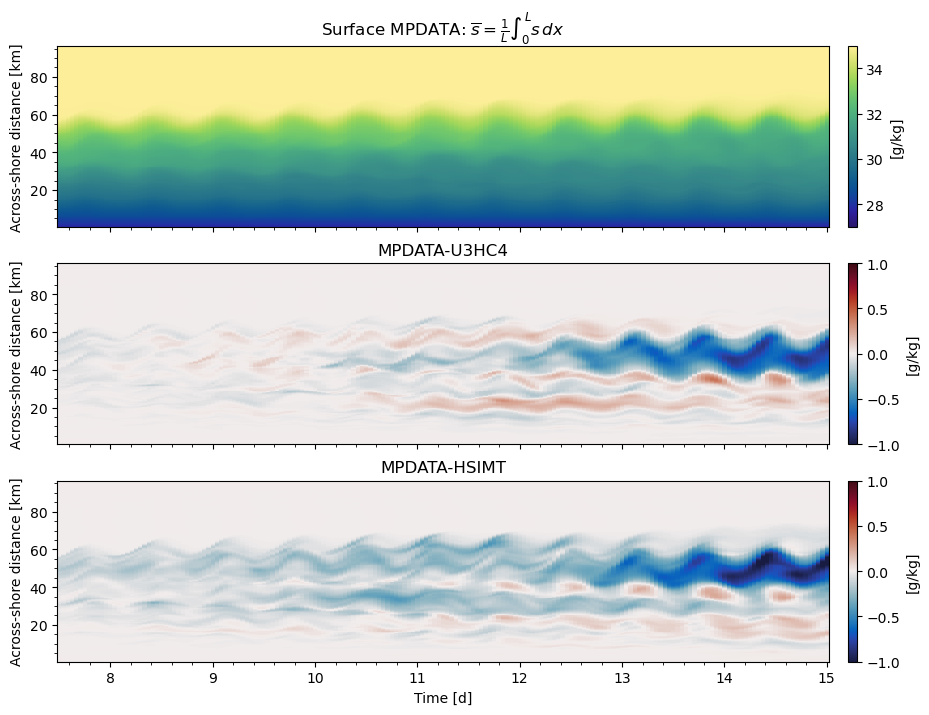

In [92]:
smean = ds[0].salt.isel(ocean_time = tslice, s_rho = -1, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()
smean1 = ds[1].salt.isel(ocean_time = tslice, s_rho = -1, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()
smean2 = ds[2].salt.isel(ocean_time = tslice, s_rho = -1, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()

t = np.arange(0,len(vhist[0].ocean_time))/24
t+=7.5
Y,T = np.meshgrid((ds[0].y_rho.isel(eta_rho = slice(1,-1), xi_rho = slice(1,-1))[:,0]/1000),t)

fig, ax = plt.subplots(3,1, figsize = (12,8))

m = ax[0].pcolormesh(T, Y, smean, cmap = cmo.haline, vmin = 27, vmax = 35)
m1 = ax[1].pcolormesh(T, Y, smean-smean1, cmap = cmo.balance, vmin = -1, vmax = 1)
m2 = ax[2].pcolormesh(T, Y, smean-smean2, cmap = cmo.balance, vmin = -1, vmax = 1)

fig.colorbar(m, ax = ax[0], label = r'[g/kg]', pad = 0.02)
fig.colorbar(m1, ax = ax[1], label = r'[g/kg]', pad = 0.02)
fig.colorbar(m2, ax = ax[2], label = r'[g/kg]', pad = 0.02)

for i in range(2):
    ax[i].set_xticklabels('')
for i in range(3):
    ax[i].minorticks_on()
    ax[i].set_ylabel('Across-shore distance [km]')
    
ax[0].set_title(r'Surface MPDATA: $\overline{s} = \frac{1}{L} \int_{0}^{L} s \, dx$')
ax[1].set_title('MPDATA-U3HC4')
ax[2].set_title('MPDATA-HSIMT')
ax[-1].set_xlabel('Time [d]')

### I hypothesize that the differences in along-shore averaged surface salinity are due to differences in mixing
> - U3HC4 and HSIMT have a generally saltier bias as a function of across-shore distance
> - MPDATA has greater numerical mixing at fronts, but much less when integrated over the whole control volume relative to other schemes
> - Does it have a fresher bias because numerical mixing drives a diahaline salt flux shoreward?
> - Repeat the same calculation, but for the bottom layer

Text(0.5, 0, 'Time [d]')

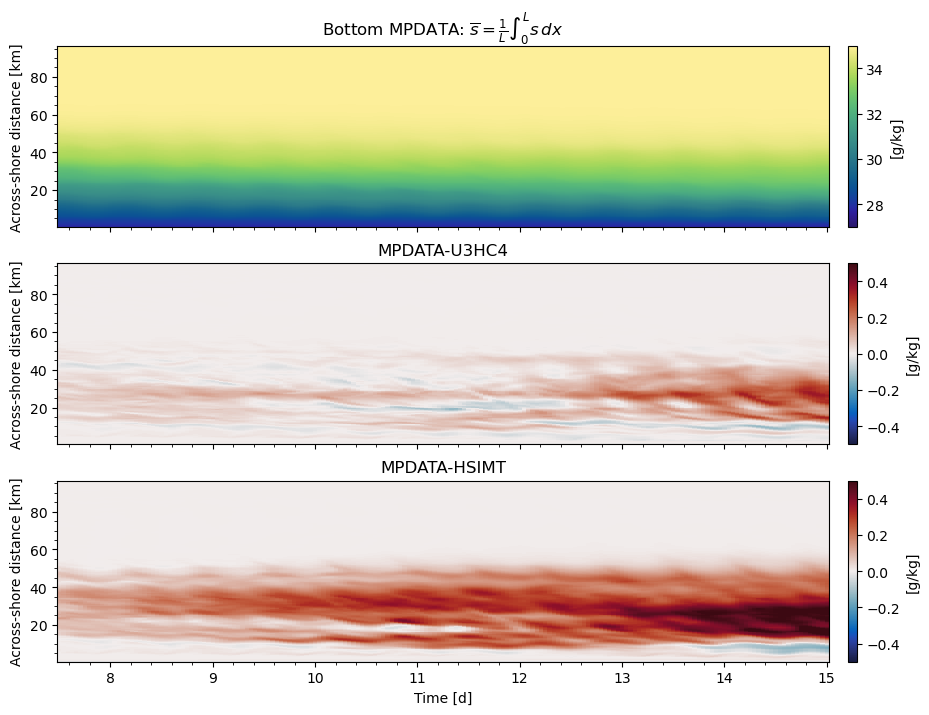

In [91]:
smean = ds[0].salt.isel(ocean_time = tslice, s_rho = 0, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()
smean1 = ds[1].salt.isel(ocean_time = tslice, s_rho = 0, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()
smean2 = ds[2].salt.isel(ocean_time = tslice, s_rho = 0, eta_rho = slice(1,-1), xi_rho = slice(1,-1)).mean(['xi_rho']).load()

t = np.arange(0,len(vhist[0].ocean_time))/24
t+=7.5
Y,T = np.meshgrid((ds[0].y_rho.isel(eta_rho = slice(1,-1), xi_rho = slice(1,-1))[:,0]/1000),t)

fig, ax = plt.subplots(3,1, figsize = (12,8))

m = ax[0].pcolormesh(T, Y, smean, cmap = cmo.haline, vmin = 27, vmax = 35)
m1 = ax[1].pcolormesh(T, Y, smean-smean1, cmap = cmo.balance, vmin = -0.5, vmax = 0.5)
m2 = ax[2].pcolormesh(T, Y, smean-smean2, cmap = cmo.balance, vmin = -0.5, vmax = 0.5)

fig.colorbar(m, ax = ax[0], label = r'[g/kg]', pad = 0.02)
fig.colorbar(m1, ax = ax[1], label = r'[g/kg]', pad = 0.02)
fig.colorbar(m2, ax = ax[2], label = r'[g/kg]', pad = 0.02)

for i in range(2):
    ax[i].set_xticklabels('')
for i in range(3):
    ax[i].minorticks_on()
    ax[i].set_ylabel('Across-shore distance [km]')
    
ax[0].set_title(r'Bottom MPDATA: $\overline{s} = \frac{1}{L} \int_{0}^{L} s \, dx$')
ax[1].set_title('MPDATA-U3HC4')
ax[2].set_title('MPDATA-HSIMT')
ax[-1].set_xlabel('Time [d]')

### The bottom differences are smaller unsurprisingly, however MPDATA almost always has a much fresher bias. 
> - MPDATA has substantially stronger physical mixing, which drives salinity more towards intermediate values, hence the fresher bias at the bottom 